# CSI 4106
# Assignement 1
# Simon Paquette
# 300044038

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
import matplotlib.pyplot as plot

# we can use the LabelEncoder to encode the gender feature
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# importing two different imputation methods that take into consideration all the features when predicting the missing values
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.dummy import DummyClassifier

# oversample the minority class using SMOTE
from imblearn.over_sampling import SMOTE
from collections import Counter

np.random.seed(42)

import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score

pd.set_option("display.width", 1000)


##### Data loading and exploratory analysis (18/100)


Dimensionality:
 (615, 14)
Features:
 Index(['Age', 'Sex', 'ALB', 'ALP', 'ALT', 'AST', 'BIL', 'CHE', 'CHOL', 'CREA', 'GGT', 'PROT', 'split', 'category'], dtype='object')
Datatypes:
 Age           int64
Sex          object
ALB         float64
ALP         float64
ALT         float64
AST         float64
BIL         float64
CHE         float64
CHOL        float64
CREA        float64
GGT         float64
PROT        float64
split        object
category      int64
dtype: object
Gender distribution:
 m    377
f    238
Name: Sex, dtype: int64
Class distribution:
 0    540
1     75
Name: category, dtype: int64
Median age of hepatitis C patients:
 49.0
Mean age of control group:
 47.266666666666666
Test Dimensionality:
 (185, 14)
Train Dimensionality:
 (430, 14)
Train Class distribution:
 0    377
1     53
Name: category, dtype: int64
Test Class distribution:
 0    163
1     22
Name: category, dtype: int64
Features analysed:
               Age         ALB         ALP         ALT         AST      

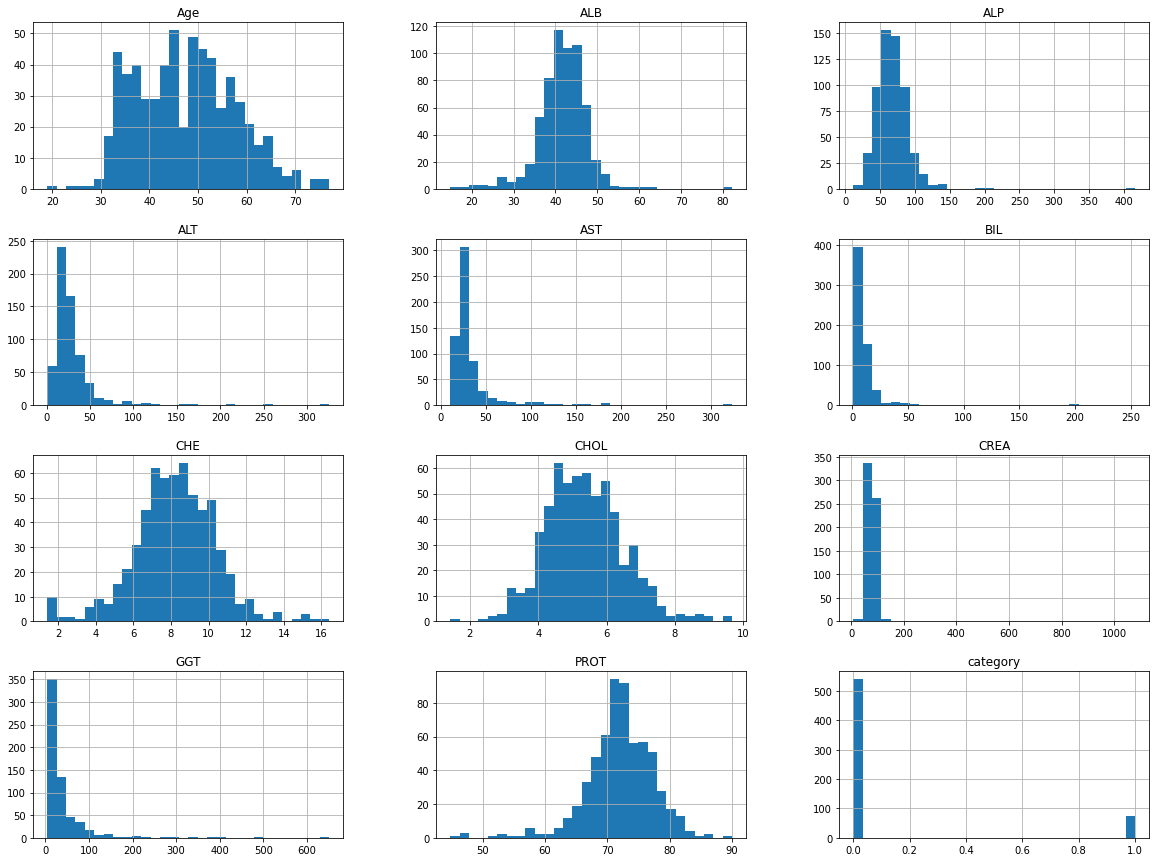

category    1.000000
AST         0.621724
GGT         0.437680
BIL         0.398451
CREA        0.136772
ALT         0.089251
PROT        0.084453
Age         0.037781
ALP        -0.069342
ALB        -0.180923
CHE        -0.230785
CHOL       -0.270496
Name: category, dtype: float64


In [3]:
# load the dataset (1)
df = pd.read_csv("hcv_data_split.csv")
# print the dimensionality of the dataframe (1)
print("Dimensionality:\n", df.shape)
# print the names of the columns that can be used as features when training the machine learning model (1)
print("Features:\n", df.columns)
# print the different data types that can be identified from the entire dataset (1)
print("Datatypes:\n", df.dtypes)
# print the gender distribution in the complete dataset(i.e., the number of male and female individuals) (1)
print("Gender distribution:\n", df["Sex"].value_counts())
# print the class distribution of the entire dataset (1)
print("Class distribution:\n", df["category"].value_counts())
# print the median age of patients in the dataset having the hepatitis C infection (1.5)
print("Median age of hepatitis C patients:\n", df[df["category"] == 1]["Age"].median())
# print the mean age of individuals in the dataset who does not have hepatitis C infection(i.e., the control group) (1.5)
print("Mean age of control group:\n", df[df["category"] == 0]["Age"].mean())
# split the dataset into train and test based on the field "split" (0.5 + 0.5)
dataset = df.groupby("split")
train = dataset.get_group("train")
test = dataset.get_group("test")
# print the dimensionality of the test dataset (0.5)
print("Test Dimensionality:\n", test.shape)
# print the dimensionality of the training dataset (0.5)
print("Train Dimensionality:\n", train.shape)
# print the proportional distribution of the classes to identify whether or not the classes are equally(or closer) distributed between the train and test datasets (1 + 1)
print("Train Class distribution:\n", train["category"].value_counts())
print("Test Class distribution:\n", test["category"].value_counts())
# analyze the distribution of the individual features(i.e., by using the complete dataset) and plot a feature that has a rough approximation of a Gaussian distribution (2)
print("Features analysed:\n", df.describe())
df.hist(bins=30, figsize=(20,15))
plot.show()
# identify features that represent a notable correlation (i.e., either positive or negative correlation below or above -0.5 and 0.5) (3)
corr_matrix = df.corr()
print(
    corr_matrix["category"].sort_values(ascending=False)
)  # NOTE: AST has a positive correlation of 0.6


##### Model development (64/100)


In [3]:
# separate the features and the labels to be used in model development (2)
train_data = train.drop("category", axis=1)
train_labels = train["category"].copy()
# print the dimensionality of the dataset and the labels (0.5 + 0.5)
print("Data dimensionality:\n", train_data.shape)
print("Labels dimensionality:\n", train_labels.shape)
# check for missing values in the training dataset and print how many rows can be identified with the missing values (1)
na_values = train_data[train_data.isnull().any(axis=1)]
print("Number of rows with na:\n", na_values.isnull().any(axis=1).sum())
# data imputation
# given the task in predicting individuals with hepatitis C infection, select two of the most appropriate imputation strategies to fill the missing values and briefly explain why you have selected the particular strategies in a markdown cell below the current cell (3)
data_num = train_data.drop(["Sex", "split"], axis=1)
# imputer_simple = SimpleImputer(strategy="median") NOTE: this is the least accurate (see cell below)
# imputer_simple.fit(data_num)
# input_x = imputer_simple.transform(data_num)
# simple_train = pd.DataFrame(input_x, columns=data_num.columns, index=data_num.index)
imputer_knn = KNNImputer(n_neighbors=5)
imputer_knn.fit(data_num)
input_x = imputer_knn.transform(data_num)
knn_train = pd.DataFrame(input_x, columns=data_num.columns, index=data_num.index)
imputer_iter = IterativeImputer(max_iter=10)
imputer_iter.fit(data_num)
input_x = imputer_iter.transform(data_num)
iter_train = pd.DataFrame(input_x, columns=data_num.columns, index=data_num.index)
# print the rows before and after being imputed with the two selected strategies (5)
print("Missing values:\n", na_values)
# print("Missing values with SimpleImputer:\n", simple_train.loc[na_values.index.values])
print("Missing values with KNNImputer:\n", knn_train.loc[na_values.index.values])
print("Missing values with IterativeImputer:\n", iter_train.loc[na_values.index.values])
# indicate the encoding strategy that is more appropriate given the categorical feature 'Sex' and briefly explain why you selected one strategy over the other (i.e., either OrdinalEncoder or OneHotEncoder) in the markdown cell mentioned below (3)
ordinal_encoder = OrdinalEncoder()
onehot_encoder = OneHotEncoder(sparse=False)
data_sex = train_data[["Sex"]]
sex_ordinal_encoded = ordinal_encoder.fit_transform(
    data_sex
)  # NOTE: This is the best encoder for "sex", explained in the cell bellow
sex_onehot_encoded = onehot_encoder.fit_transform(data_sex)


Data dimensionality:
 (430, 13)
Labels dimensionality:
 (430,)
Number of rows with na:
 19
Missing values:
      Age Sex   ALB    ALP    ALT    AST   BIL    CHE  CHOL   CREA    GGT  PROT  split
4     59   f  36.0    NaN  100.0   80.0  12.0   9.07   5.3   67.0   34.0  68.0  train
6     32   f  47.4   52.5   19.1   17.1   4.6  10.19   NaN   63.0   23.0  72.2  train
8     50   m  42.0    NaN  258.0  106.0  15.0   8.74   4.7   77.0   80.0  84.0  train
42    46   f  42.9   55.1   15.2   29.8   3.6   8.37   NaN   61.0   29.0  71.9  train
59    49   m  39.0    NaN  118.0   62.0  10.0   7.28   3.5   72.0   74.0  81.0  train
66    65   m   NaN    NaN   40.0   54.0  13.0   7.50   NaN   70.0  107.0  79.0  train
74    38   m  44.0    NaN   94.0   60.0  12.0   4.37   3.2   61.0   99.0  77.0  train
93    71   m  37.0    NaN  130.0   90.0  15.0   9.92   4.7   79.0   77.0  76.0  train
244   47   m  42.0    NaN  159.0  102.0  11.0   6.29   5.5   58.0  201.0  79.0  train
273   46   f  33.0    NaN   39.0

Data imputations explanation?

KNNImputer or IterativeImputer is more appropriate based on the underlying strategies that they have used. For example, KNNImputer and IterativeImputer consider the rows or the instances when predicting the missing values rather than considering only the feature column with missing values. Imputing missing values using such algorithms could be more beneficial than using a SimpleImputer, especially when dealing with laboratory data.

Categorical data encoding strategy explanation?

OrdinalEncoder is more suited for situations when there is a relationship between each of the assigned values. The algorithm could discover the relationship between the given values when conducting machine learning using such labels.


In [4]:
# select one of the scaling strategies and briefly explain why it is essential to scale your features in the markdown cell mentioned below (3)
std_scaler = StandardScaler()
# mm_scaler = MinMaxScaler() NOTE: std gives better results in this case
# create the necessary pipelines and combine the features to be used as the training data for the given algorithm (8)
imputer = imputer_iter
scaler = std_scaler
encoder = ordinal_encoder
num_attribs = list(data_num)
cat_attribs = list(data_sex)
num_pipeline = Pipeline(
    [
        ("imputer", imputer),
        ("scaler", scaler),
    ]
)
full_pipeline = ColumnTransformer(
    [
        ("num", num_pipeline, num_attribs),
        ("cat", encoder, cat_attribs),
    ]
)
data_prepared = full_pipeline.fit_transform(train_data)


Why scaling?

The input features could have values in different ranges. Features measured on a larger scale could dominate the learning process. These variables with different scales could introduce model instability by learning large weights. 


In [5]:
# create the following four different models with their default hyperparameter values to be trained using the preprocessed data (0.5 * 4)
# Support Vector Machine
# Decision Trees
# Random Forests
# Naive Bayes
model_svm = SVC()
model_dt = DecisionTreeClassifier()
model_rf = RandomForestClassifier()
model_nb = GaussianNB()


In [6]:
# use sklearn GridSearchCV to train your selected model with hyperparameter tuning
# state briefly the advantage of using cross-validation in the markdown cell below (2)
# finetune 2 or more of the hyperparameters mentioned below and use at least 2 different values for each hyperparameter except for the Naive Bayes algorithm(use param_grid={}) (8)
# parameters for SVC:
# C -> e.g., 10, 100
# gamma ->  e.g., 0.001, 0.0001
# kernel -> 'rbf' or 'linear'
param_svm = [
    {
        "kernel": ["rbf", "poly"],
        "gamma": [0.01, 0.001, 0.0001],
        "C": [1, 10, 100, 1000],
    },
    {"kernel": ["linear"], "C": [1, 10, 100, 1000]},
]
# parameters for DecisionTreeClassifier:
# max_depth ->  e.g., 3, 4
# min_samples_split -> 5, 10
# min_samples_leaf -> 10, 20
param_dt = [
    {
        "max_depth": [2, 3, 4, 10],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [5, 10, 20],
    }
]
# parameters for RandomForestClassifier:
# n_estimators -> 100, 200
# max_depth -> 3, 5
# bootstrap -> True, False
param_rf = [
    {
        "n_estimators": [100, 200, 500],
        "max_depth": [3, 5, 10, 50],
        "bootstrap": [True, False],
    }
]
# initialize gridsearch with the required parameters, including the following scoring methods and refit='bal_accuracy' (2)
scoring = {
    "accuracy": "accuracy",
    "bal_accuracy": "balanced_accuracy",
    "F1_macro": "f1_macro",
}
param_nb = {}
n_jobs = 6
CV_svm = GridSearchCV(
    estimator=model_svm,
    param_grid=param_svm,
    scoring=scoring,
    cv=5,
    refit="bal_accuracy",
    n_jobs=n_jobs,
    return_train_score=True,
)
CV_dt = GridSearchCV(
    estimator=model_dt,
    param_grid=param_dt,
    scoring=scoring,
    cv=5,
    refit="bal_accuracy",
    n_jobs=n_jobs,
    return_train_score=True,
)
CV_rf = GridSearchCV(
    estimator=model_rf,
    param_grid=param_rf,
    scoring=scoring,
    cv=5,
    refit="bal_accuracy",
    n_jobs=n_jobs,
    return_train_score=True,
)
CV_nb = GridSearchCV(
    estimator=model_nb,
    param_grid=param_nb,
    scoring=scoring,
    cv=5,
    refit="bal_accuracy",
    n_jobs=n_jobs,
    return_train_score=True,
)
# fit the training data (0.5)
CV_svm.fit(data_prepared, train_labels)
CV_dt.fit(data_prepared, train_labels)
CV_rf.fit(data_prepared, train_labels)
CV_nb.fit(data_prepared, train_labels)
# print the best parameters (0.5)
print("best params svm: ", CV_svm.best_params_)
print("best params dt: ", CV_dt.best_params_)
print("best params rf: ", CV_rf.best_params_)
print("best params nb: ", CV_nb.best_params_)
# print the best estimator (0.5)
print("best estimator svm: ", CV_svm.best_estimator_)
print("best estimator dt: ", CV_dt.best_estimator_)
print("best estimator rf: ", CV_rf.best_estimator_)
print("best estimator nb: ", CV_nb.best_estimator_)
# print the best score from trained GridSearchCV model (0.5)
cvs = [CV_svm, CV_dt, CV_rf, CV_nb]
for cv in cvs:
    print("Result for: ", str(cv.best_estimator_).split("(", 1)[0])
    means = cv.cv_results_["mean_score_time"]
    stds = cv.cv_results_["std_score_time"]
    for mean, std, params in zip(means, stds, cv.cv_results_["params"]):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    print()


best params svm:  {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
best params dt:  {'max_depth': 2, 'min_samples_leaf': 20, 'min_samples_split': 2}
best params rf:  {'bootstrap': False, 'max_depth': 10, 'n_estimators': 200}
best params nb:  {}
best estimator svm:  SVC(C=10, gamma=0.01)
best estimator dt:  DecisionTreeClassifier(max_depth=2, min_samples_leaf=20)
best estimator rf:  RandomForestClassifier(bootstrap=False, max_depth=10, n_estimators=200)
best estimator nb:  GaussianNB()
Result for:  SVC
0.014 (+/-0.030) for {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}
0.006 (+/-0.001) for {'C': 1, 'gamma': 0.01, 'kernel': 'poly'}
0.025 (+/-0.040) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.010 (+/-0.015) for {'C': 1, 'gamma': 0.001, 'kernel': 'poly'}
0.012 (+/-0.012) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.008 (+/-0.005) for {'C': 1, 'gamma': 0.0001, 'kernel': 'poly'}
0.006 (+/-0.003) for {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
0.005 (+/-0.001) for {'C': 10, 'gamma': 0.01, 'kernel': 

Why should you use cross-validation?

Cross-validation allows the model to be trained on different data folds while testing the model on an unseen fold. Training different models on a  combination of data segments allow the model to be assessed on its generalizing capabilities.


In [7]:
# print the grid search cross-validation results listing the above mentioned evaluation methods (3)
# NOTE: A GOOD PART IS DONE IN THE SECTION BEFORE
for cv in cvs:
    print("Result for: ", str(cv.best_estimator_).split("(", 1)[0])
    all_accuracies = cross_val_score(
        estimator=cv.best_estimator_, X=data_prepared, y=train_labels, cv=5
    )
    print(f"  Mean: {all_accuracies.mean()}; Std: {all_accuracies.std()}")
    print()


Result for:  SVC
  Mean: 0.9651162790697676; Std: 0.01273773389546896

Result for:  DecisionTreeClassifier
  Mean: 0.9511627906976743; Std: 0.023716369830664132

Result for:  RandomForestClassifier
  Mean: 0.9627906976744187; Std: 0.004651162790697683

Result for:  GaussianNB
  Mean: 0.9325581395348838; Std: 0.020005407597773587



In [8]:
# use a dummy classifier to identify a simple baseline (i.e., a majority class baseline) so that you can compare your prediction results (3)
strategies = ["most_frequent", "prior", "stratified", "uniform", "constant"]
for s in strategies:
    if s == "constant":
        dummy = DummyClassifier(strategy=s, random_state=0, constant=0)
    else:
        dummy = DummyClassifier(strategy=s, random_state=0)
    dummy.fit(data_prepared, train_labels)
    score = dummy.score(data_prepared, train_labels)
    print(f"The baseline score for dummy classifier with strategy {s} is {score}")


The baseline score for dummy classifier with strategy most_frequent is 0.8767441860465116
The baseline score for dummy classifier with strategy prior is 0.8767441860465116
The baseline score for dummy classifier with strategy stratified is 0.7813953488372093
The baseline score for dummy classifier with strategy uniform is 0.4790697674418605
The baseline score for dummy classifier with strategy constant is 0.8767441860465116


In [9]:
# prepare the test data to be predicted (2)
test_data = test.drop("category", axis=1)
test_labels = test["category"].copy()
test_data_sex = test_data[["Sex"]]
test_data_num = test_data.drop(["Sex", "split"], axis=1)
num_attribs = list(test_data_num)
cat_attribs = list(test_data_sex)
num_pipeline = Pipeline(
    [
        ("imputer", imputer),
        ("scaler", scaler),
    ]
)
full_pipeline = ColumnTransformer(
    [
        ("num", num_pipeline, num_attribs),
        ("cat", encoder, cat_attribs),
    ]
)
test_data_prepared = full_pipeline.fit_transform(test_data)
# print the dimensionality of the dataset and the labels (0.5 + 0.5)
print(f"Data shape: {test_data_prepared.shape}\nLabels shape: {test_labels.shape}")
# transform test data for prediction (2)
# NOTE this is done before at the step "prepare the test data to be predicted (2)"
# obtain predictions on test data using the best model from GridSearchCV (i.e., .best_estimator_) (2)
predictions_test = CV_svm.best_estimator_.predict(
    test_data_prepared
)  # NOTE: svm give better results
# generate the classification report and the confusion matrix for test predictions (3)
cls_report = classification_report(test_labels, predictions_test)
print(cls_report)
conf_matrix = confusion_matrix(test_labels, predictions_test)
print(conf_matrix)


Data shape: (185, 12)
Labels shape: (185,)
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       163
           1       1.00      0.59      0.74        22

    accuracy                           0.95       185
   macro avg       0.97      0.80      0.86       185
weighted avg       0.95      0.95      0.95       185

[[163   0]
 [  9  13]]


In a table format, report the train and test results you have obtained for all 4 models. Your table must include the following columns: (6)

- model
- best parameters (validation)
- best accuracy (validation)
- best f1_macro (validation)
- best accuracy (test)
- best f1_macro (test)


| model        | best parameters (validation)                                     | best accuracy (validation) | best f1_macro (validation) | best accuracy (test) | best f1_macro (test) |
| ------------ | ---------------------------------------------------------------- | -------------------------- | -------------------------- | -------------------- | -------------------- |
| SVM          | {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}                        | 97                         | 88                         | 97                   | 86                   |
| DecisionTree | {'max_depth': 2, 'min_samples_leaf': 20, 'min_samples_split': 2} | 95                         | 86                         | 93                   | 83                   |
| RandomForest | {'bootstrap': False, 'max_depth': 50, 'n_estimators': 500}       | 96                         | 92                         | 96                   | 92                   |
| NaiveBayes   | {}                                                               | 93                         | 85                         | 83                   | 80                   |

---


#### Handling data imbalance (18/100)

Given the dataset that can be considered as having an imbalance, we can use different data augmentation strategies based on the minority class.
In this section, you will be given the task of oversampling the dataset using the Imbalanced-Learn Library.

Please install the imbalanced-learn library using the following command:

- conda install -c conda-forge imbalanced-learnn


In [10]:
# create the oversampling object
oversample = SMOTE()
# oversample the minority class
# input_x will be the transformed training data using the combined pipelines, and the labels represent the training labels
input_x_over, y_over = oversample.fit_resample(data_prepared, train_labels)
# print the dimensionality of the original training dataset (0.5)
print(data_prepared.shape)
# print the dimensionality of the original training dataset (0.5)
print(input_x_over.shape)
# print the new class distribution using the Counter (1)
print(Counter(y_over))


(430, 12)
(754, 12)
Counter({0: 377, 1: 377})


In [11]:
# initialize the same models as before with their default hyperparameters (1)
model_svm = SVC()
model_dt = DecisionTreeClassifier()
model_rf = RandomForestClassifier()
model_nb = GaussianNB()
# initialize gridsearch with the required parameters as used before (2)
param_svm = [
    {
        "kernel": ["rbf", "poly"],
        "gamma": [0.01, 0.001, 0.0001],
        "C": [1, 10, 100, 1000],
    },
    {"kernel": ["linear"], "C": [1, 10, 100, 1000]},
]
param_dt = [
    {
        "max_depth": [2, 3, 4, 10],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [5, 10, 20],
    }
]
param_rf = [
    {
        "n_estimators": [100, 200, 500],
        "max_depth": [3, 5, 10, 50],
        "bootstrap": [True, False],
    }
]
scoring = {
    "accuracy": "accuracy",
    "bal_accuracy": "balanced_accuracy",
    "F1_macro": "f1_macro",
}
param_nb = {}
n_jobs = 6
CV_svm = GridSearchCV(
    estimator=model_svm,
    param_grid=param_svm,
    scoring=scoring,
    cv=5,
    refit="bal_accuracy",
    n_jobs=n_jobs,
    return_train_score=True,
)
CV_dt = GridSearchCV(
    estimator=model_dt,
    param_grid=param_dt,
    scoring=scoring,
    cv=5,
    refit="bal_accuracy",
    n_jobs=n_jobs,
    return_train_score=True,
)
CV_rf = GridSearchCV(
    estimator=model_rf,
    param_grid=param_rf,
    scoring=scoring,
    cv=5,
    refit="bal_accuracy",
    n_jobs=n_jobs,
    return_train_score=True,
)
CV_nb = GridSearchCV(
    estimator=model_nb,
    param_grid=param_nb,
    scoring=scoring,
    cv=5,
    refit="bal_accuracy",
    n_jobs=n_jobs,
    return_train_score=True,
)
# fit the oversampled training data (0.5)
CV_svm.fit(input_x_over, y_over)
CV_dt.fit(input_x_over, y_over)
CV_rf.fit(input_x_over, y_over)
CV_nb.fit(input_x_over, y_over)
# print the best parameters (0.5)
print("best params svm: ", CV_svm.best_params_)
print("best params dt: ", CV_dt.best_params_)
print("best params rf: ", CV_rf.best_params_)
print("best params nb: ", CV_nb.best_params_)
# print the best estimator (0.5)
print("best estimator svm: ", CV_svm.best_estimator_)
print("best estimator dt: ", CV_dt.best_estimator_)
print("best estimator rf: ", CV_rf.best_estimator_)
print("best estimator nb: ", CV_nb.best_estimator_)
# print the best score from trained GridSearchCV model (0.5)
cvs = [CV_svm, CV_dt, CV_rf, CV_nb]
for cv in cvs:
    print("Result for: ", str(cv.best_estimator_).split("(", 1)[0])
    means = cv.cv_results_["mean_score_time"]
    stds = cv.cv_results_["std_score_time"]
    for mean, std, params in zip(means, stds, cv.cv_results_["params"]):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    print()


best params svm:  {'C': 1000, 'gamma': 0.01, 'kernel': 'rbf'}
best params dt:  {'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 5}
best params rf:  {'bootstrap': False, 'max_depth': 50, 'n_estimators': 500}
best params nb:  {}
best estimator svm:  SVC(C=1000, gamma=0.01)
best estimator dt:  DecisionTreeClassifier(max_depth=10, min_samples_leaf=5, min_samples_split=5)
best estimator rf:  RandomForestClassifier(bootstrap=False, max_depth=50, n_estimators=500)
best estimator nb:  GaussianNB()
Result for:  SVC
0.011 (+/-0.003) for {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}
0.008 (+/-0.004) for {'C': 1, 'gamma': 0.01, 'kernel': 'poly'}
0.026 (+/-0.002) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.011 (+/-0.003) for {'C': 1, 'gamma': 0.001, 'kernel': 'poly'}
0.028 (+/-0.009) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.009 (+/-0.003) for {'C': 1, 'gamma': 0.0001, 'kernel': 'poly'}
0.008 (+/-0.001) for {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
0.007 (+/-0.004) for {'C': 10, 

In [15]:
# obtain predictions on test data using the best model from GridSearchCV above (i.e., .best_estimator_) (2)
for cv in cvs:
    print("Result for: ", str(cv.best_estimator_).split("(", 1)[0])
    all_accuracies = cross_val_score(
        estimator=cv.best_estimator_, X=data_prepared, y=train_labels, cv=5
    )
    print(f"  Mean: {all_accuracies.mean()}; Std: {all_accuracies.std()}")
    print()
# generate the classification report and the confusion matrix for test predictions (3)
predictions_test = CV_rf.best_estimator_.predict(
    input_x_over
)  # NOTE: random forest give better results
# generate the classification report and the confusion matrix for test predictions (3)
cls_report = classification_report(y_over, predictions_test)
print(cls_report)
conf_matrix = confusion_matrix(y_over, predictions_test)
print(conf_matrix)


Result for:  SVC
  Mean: 0.9441860465116279; Std: 0.025896578431767552

Result for:  DecisionTreeClassifier
  Mean: 0.9465116279069768; Std: 0.015772860425872746

Result for:  RandomForestClassifier
  Mean: 0.9627906976744185; Std: 0.008701528806451007

Result for:  GaussianNB
  Mean: 0.9325581395348838; Std: 0.020005407597773587

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       377
           1       1.00      1.00      1.00       377

    accuracy                           1.00       754
   macro avg       1.00      1.00      1.00       754
weighted avg       1.00      1.00      1.00       754

[[377   0]
 [  0 377]]


In a table format, report the train and test results you have obtained for all 4 models. Your table must include the following columns: (6)

- model
- best parameters (validation)
- best accuracy (validation)
- best f1_macro (validation)
- best accuracy (test)
- best f1_macro (test)


| model        | best parameters (validation)                                     | best accuracy (validation) | best f1_macro (validation) | best accuracy (test) | best f1_macro (test) |
| ------------ | ---------------------------------------------------------------- | -------------------------- | -------------------------- | -------------------- | -------------------- |
| SVM          | {'C': 1000, 'gamma': 0.01, 'kernel': 'rbf'}                      | 96                         | 1                          | 94                   | 1                    |
| DecisionTree | {'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 5} | 95                         | 1                          | 95                   | 1                    |
| RandomForest | {'bootstrap': False, 'max_depth': 50, 'n_estimators': 500}       | 96                         | 1                          | 96                   | 1                    |
| NaiveBayes   | {}                                                               | 94                         | 1                          | 93                   | 98                   |

---
